# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://docs.langchain.com/oss/python/langgraph/use-graph-api#map-reduce-and-the-send-api).

In [15]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [18]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [20]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [ ]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 4 sub-topics that are all related to this overall topic: {topic}."""
trivia_prompt = """Generate a  trivia about {subject}"""
best_trivia_prompt = """Below are a bunch of trivia about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first trivia. Trivias: \n\n  {trivias}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [22]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestTrivia(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    trivias: Annotated[list, operator.add]
    best_selected_trivia: str

Generate subjects for jokes.

In [24]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

Here is the magic: we use the  [Send](https://docs.langchain.com/oss/python/langgraph/graph-api/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [25]:
from langgraph.types import Send
def continue_to_trivias(state: OverallState):
    return [Send("generate_trivia", {"subject": s}) for s in state["subjects"]]

### Joke generation (map)

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`! 

This key has a reducer that will combine lists.

In [27]:
class TriviaState(TypedDict):
    subject: str

class Trivia(BaseModel):
    trivia: str

def generate_trivia(state: TriviaState):
    prompt = trivia_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Trivia).invoke(prompt)
    return {"trivias": [response.trivia]}

### Best joke selection (reduce)

Now, we add logic to pick the best joke.

In [29]:
def best_trivia(state: OverallState):
    trivias = "\n\n".join(state["trivias"])
    prompt = best_trivia_prompt.format(topic=state["topic"], trivias=trivias)
    response = model.with_structured_output(BestTrivia).invoke(prompt)
    return {"best_selected_trivia": state["trivias"][response.id]}

## Compile

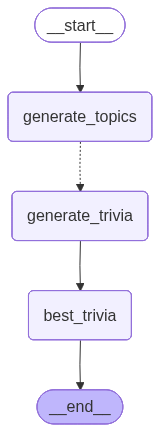

In [31]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_trivia", generate_trivia)
graph.add_node("best_trivia", best_trivia)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_trivias, ["generate_trivia"])
graph.add_edge("generate_trivia", "best_trivia")
graph.add_edge("best_trivia", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [32]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "science"}):
    print(s)

{'generate_topics': {'subjects': ['Quantum Mechanics', 'Genetic Engineering', 'Renewable Energy Technologies']}}
{'generate_trivia': {'trivias': ["### Quantum Mechanics Trivia: The Curious Case of Schrödinger's Cat\n\n**Did you know?**\n\nOne of the most famous thought experiments in quantum mechanics is Schrödinger's Cat, proposed by Austrian physicist Erwin Schrödinger in 1935. This paradox illustrates the concept of superposition, a fundamental principle of quantum mechanics.\n\n**The Experiment:**\n- Imagine a cat placed inside a sealed box with a radioactive atom, a Geiger counter, a vial of poison, and a hammer.\n- If the Geiger counter detects radiation (i.e., the atom decays), it triggers the hammer to break the vial, releasing the poison and killing the cat.\n- If no radiation is detected, the cat remains alive.\n\n**The Paradox:**\n- According to quantum mechanics, until the box is opened and observed, the cat is simultaneously alive and dead.\n- This is because the atom exis

## Studio

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

Let's load the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.